<a href="https://colab.research.google.com/github/abhi2090k/Hachathon/blob/master/NN_based_CPM_SSB_FSK_(M%3D2%2C_L%3D7%2C_w%3D1_3%2C_h%3D1_81)_Training_with_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All required library files

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras import Sequential
from keras import regularizers
from keras.layers import Dense,Conv1D,Flatten,LSTM,MaxPooling1D
from keras.optimizers import SGD, Adam
import pydotplus
from IPython.display import Image
from tensorflow.keras.utils import model_to_dot

Defing the CRELU activation function

In [3]:
def crelu(z):
    real_part = keras.activations.relu(tf.math.real(z))
    imag_part = keras.activations.relu(tf.math.imag(z))
    return tf.complex(real_part, imag_part)

In [4]:
def Create_Pulse(pulse_length,sampling_frequency,w):
    # create time vector
    t_sa = 1/sampling_frequency
    t = np.arange(-pulse_length/2,pulse_length/2+t_sa,t_sa)
    # calculate g(t)
    t_0 = 0
    g_t = (2*w)/((t-t_0)**2+w**2)
    cst = np.sum(g_t)*t_sa
    nug_t = (2*np.pi)/cst
    g_t = nug_t*g_t
    g_t = g_t/(4*np.pi)
    #integrate g(t) to obtain q(t)
    q_t = np.cumsum(g_t)*t_sa
    return g_t, q_t, t

In [5]:
def upsample(bits,factor):
    return np.repeat(bits,factor)
def modulate_signal(bits,Fs,Fc,h,g_t,N_bits):
    Ts = 1/Fs
    bits_s = upsample(bits,Fs)
    t_seq = np.arange(0,N_bits,Ts)
    S_N = np.convolve(bits_s,g_t)/10
    S_N1 = S_N[:len(t_seq)]
    phi_N = np.cumsum(S_N1)*Ts
    return np.exp(1j * 2 * np.pi * h * phi_N),phi_N,S_N1,bits_s,t_seq

In [6]:
def AWGN(signal,snr):
    signal_power = np.sum(np.abs(signal)**2)/np.size(signal)
    snr = 10**(snr / 10)
    signal_power = 10**(signal_power/10)
    noise_power = signal_power/snr
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal+noise

In [7]:
def reshape(signal,n):
    i=0
    M = np.zeros((n,70),dtype=complex)
    aa = np.reshape(signal,(1,signal.shape[0]))
    for k in range(n):
        if i + 70 <= aa.shape[1]:
            M[k, :] = aa[0, i:i+70]
        else:
            M[k, :aa.shape[1] - i] = aa[0, i:]
        i += 10
    return M

In [8]:
g_t = Create_Pulse(7.0,10,1.3)[0]
N_bits = 100000
#np.random.seed(42)
bits = np.random.randint(2,size = N_bits)
mod_signal = modulate_signal(bits,10,100,2*1.81,g_t,N_bits)[0]
#signal_mean = np.mean(mod_signal)
#signal_std = np.std(mod_signal)
#normalized_signal = (mod_signal - signal_mean) / signal_std
phase = modulate_signal(bits,10,100,2*1.81,g_t,N_bits)[1]

In [9]:
mod_signal.shape

(1000000,)

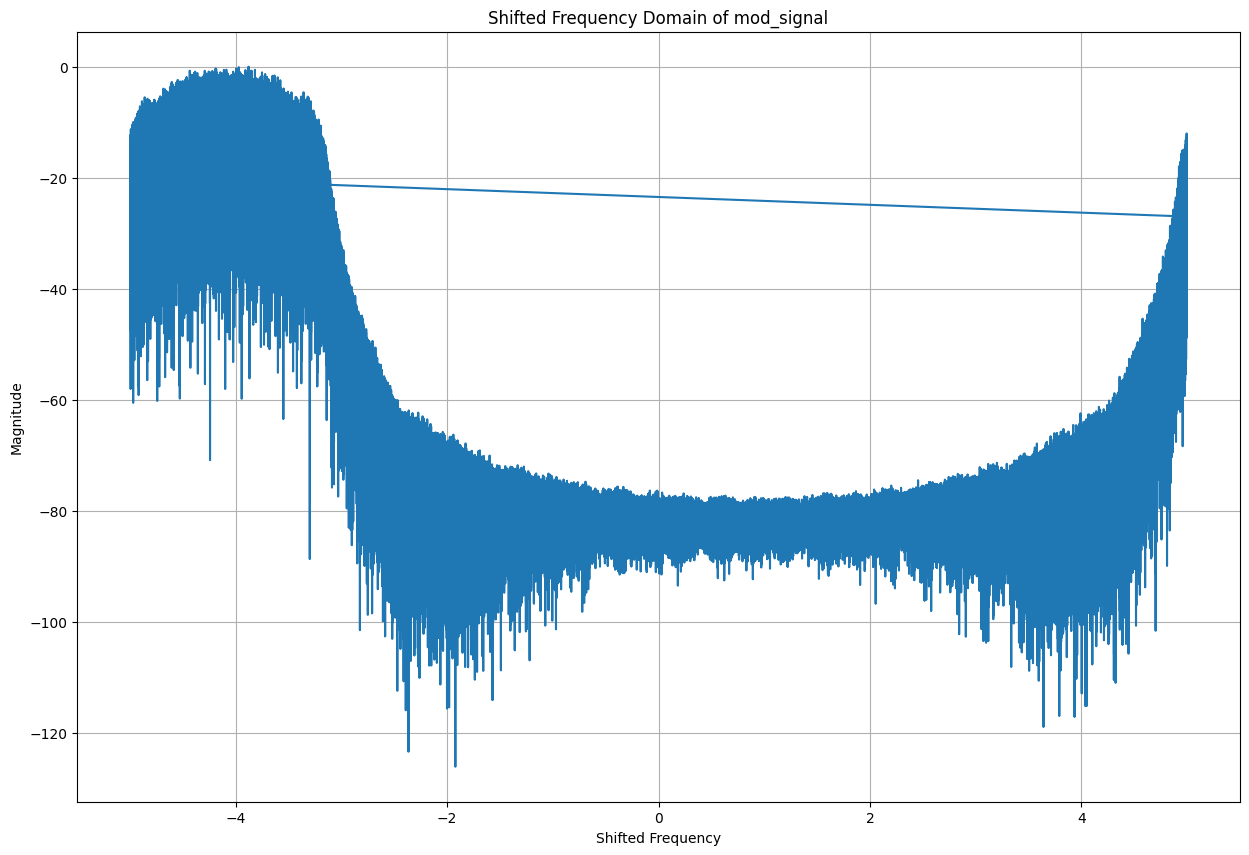

In [10]:
mod_signal_fft = np.fft.fft(mod_signal)
mod_signal_fft= mod_signal_fft/max(mod_signal_fft)
mod_signal_fft_shifted = np.fft.fftshift(mod_signal_fft)
freq = np.fft.fftfreq(len(mod_signal), d=1/10)
Y_dB = 10*np.log10(abs(mod_signal_fft_shifted)**2)
plt.figure(figsize=(15,10))
plt.plot(freq,Y_dB)
plt.xlabel('Shifted Frequency')
plt.ylabel('Magnitude')
plt.title('Shifted Frequency Domain of mod_signal')
plt.grid(True)
plt.show()

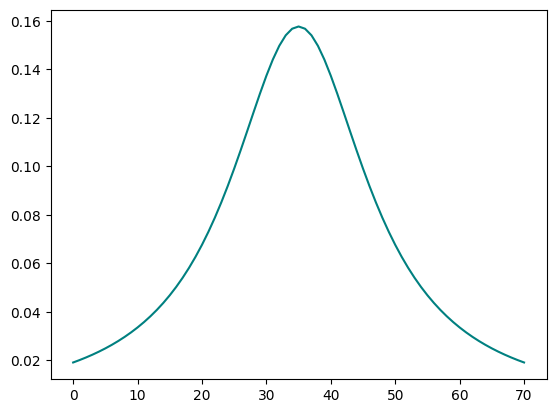

In [11]:
plt.plot(g_t,c='Teal')
plt.show()

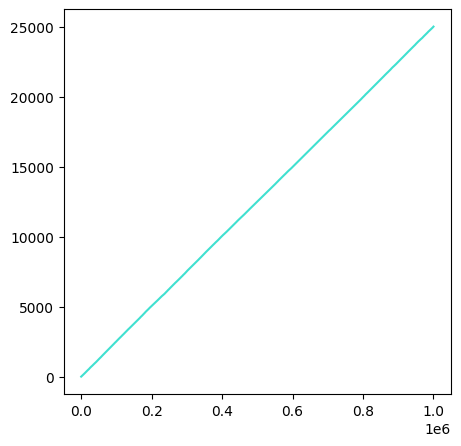

In [12]:
plt.figure(figsize=(5,5))
plt.plot(phase,c='Turquoise')
plt.show()

In [13]:
model = Sequential()
model.add(Dense(64,activation = crelu,input_shape=(70,)))
#model.add(keras.layers.Dropout(0.3))
model.add(Dense(32,activation=crelu))
#model.add(Dense(16,activation = crelu))
#model.add(Dense(8,activation=crelu))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4544      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,657
Trainable params: 6,657
Non-trainable params: 0
_________________________________________________________________


In [14]:
M = reshape(mod_signal,100000)
M.shape,bits.shape

((100000, 70), (100000,))

In [15]:
history = model.fit(M,bits,epochs=100,batch_size=32)#,#validation_data=(M_val, bits_val)

Epoch 1/100


3125/3125 [==============================] - 9s 2ms/step - loss: 0.1058 - accuracy: 0.9578
Epoch 2/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0172 - accuracy: 0.9944
Epoch 3/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.0131 - accuracy: 0.9955
Epoch 4/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0116 - accuracy: 0.9959
Epoch 5/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.0109 - accuracy: 0.9960
Epoch 6/100
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0089 - accuracy: 0.9966
Epoch 7/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.0089 - accuracy: 0.9966
Epoch 8/100
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0075 - accuracy: 0.9969
Epoch 9/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.0075 - accuracy: 0.9967
Epoch 10/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0068 

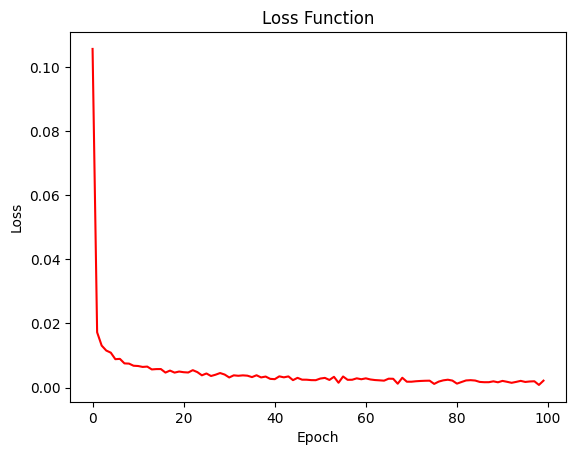

In [16]:
plt.plot(history.history['loss'],c='r')
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

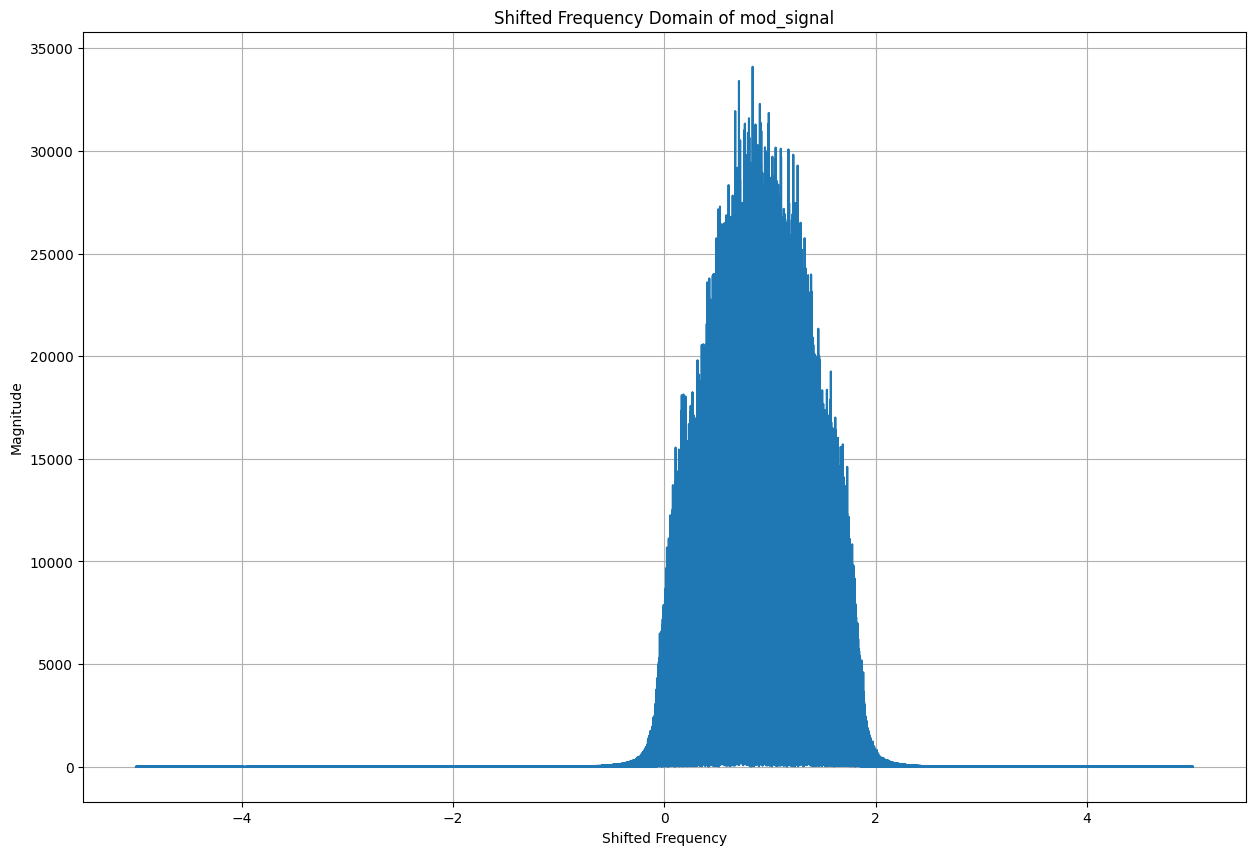

In [17]:
#np.random.seed(32)
testing_bits = np.random.randint(2,size = 1000000)
N_bits = 1000000
test_mod_signal = modulate_signal(testing_bits,10,100,2*1.81,g_t,N_bits)[0]
test_mod_signal_fft = np.fft.fft(test_mod_signal)
test_mod_signal_fft_shifted = np.fft.fftshift(test_mod_signal_fft)
freq = np.fft.fftfreq(len(test_mod_signal), d=1/10)
freq_shifted = np.fft.fftshift(freq)
plt.figure(figsize=(15,10))
plt.plot(freq_shifted, np.abs(test_mod_signal_fft_shifted))
plt.xlabel('Shifted Frequency')
plt.ylabel('Magnitude')
plt.title('Shifted Frequency Domain of mod_signal')
plt.grid(True)
plt.show()

In [18]:
test_mod_signal.shape

(10000000,)

In [19]:
N = reshape(test_mod_signal,1000000)
loss, accuracy = model.evaluate(N, testing_bits)

31250/31250 [==============================] - 47s 2ms/step - loss: 0.0011 - accuracy: 0.9995


conv_model = Sequential()
conv_model.add(Conv1D(32, kernel_size=3, activation=crelu, input_shape=(70,1)))
#conv_model.add(MaxPooling1D(pool_size=2))
conv_model.add(Flatten())
conv_model.add(Dense(64,activation=crelu))
conv_model.add(Dense(32,activation='tanh'))
conv_model.add(Dense(1,activation='sigmoid'))
conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
conv_model.summary()

In [20]:
#conv_model.fit(M,bits,epochs=100,batch_size=32)

In [21]:
#loss, accuracy = conv_model.evaluate(N, testing_bits)

In [22]:
output = model.predict(N)

31250/31250 [==============================] - 47s 1ms/step


In [23]:
for i in range(len(output)):
    if output[i]>=0.5:
        output[i]=1
    else:
        output[i]=0

In [24]:
output = output.reshape(1000000)

In [25]:
print(np.where(output!=testing_bits))

(array([ 14823,  14825,  16793,  16795,  19523,  19525,  20360,  20361,
        20362,  20363,  24245,  24928,  25316,  26549,  26550,  28988,
        28990,  32145,  36074,  36075,  36076,  36077,  39923,  42653,
        44477,  44478,  47532,  53200,  58817,  62521,  67477,  67478,
        67516,  67517,  71682,  73038,  74719,  74720,  74721,  76754,
        81730,  81772,  81852,  83834,  83835,  91374,  91782,  96994,
        97322,  97323, 100282, 101867, 103980, 108635, 109695, 110992,
       126840, 126841, 143233, 152873, 154679, 156654, 157778, 160240,
       163999, 164574, 164575, 164576, 164577, 170399, 172576, 173067,
       173068, 176624, 177120, 177122, 178011, 178012, 186575, 189928,
       193182, 194979, 199459, 213874, 220602, 221025, 221147, 221172,
       221173, 234355, 236570, 236739, 237150, 245703, 247985, 247986,
       247987, 247988, 249009, 249010, 249011, 249012, 249918, 250033,
       267291, 267293, 273728, 273729, 284106, 284107, 284108, 286901,
     

In [26]:
print(f'BER={np.linalg.norm(testing_bits-output,ord=1)/1000000}')

BER=0.000498


In [27]:
SNR = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
BER = []
for snr in SNR:
    signal = AWGN(test_mod_signal,snr)
    N1 = reshape(signal,1000000)
    output1 = model.predict(N1)
    for i in range(len(output1)):
        if output1[i]>=0.5:
            output1[i]=1
        else:
            output1[i]=0
    output1 = output1.reshape(1000000)
    BER.append(np.linalg.norm(testing_bits-output1,ord=1)/1000000)
print(BER)

31250/31250 [==============================] - 43s 1ms/step
[0.294499, 0.280609, 0.269272, 0.257379, 0.244125, 0.232171, 0.219865, 0.207682, 0.194264, 0.184159, 0.17197]


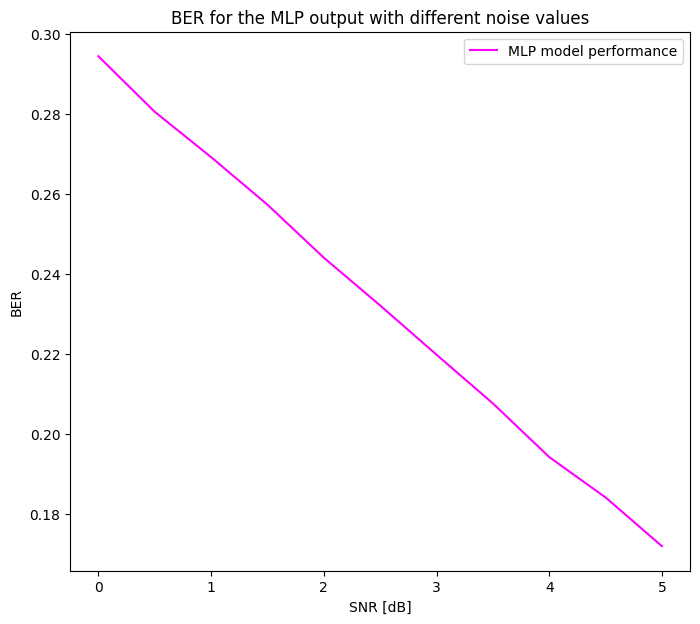

In [28]:
plt.figure(figsize=(8,7))
plt.plot(SNR,BER,color='Fuchsia',label='MLP model performance')
plt.title('BER for the MLP output with different noise values')
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend()
plt.show()

#compute BER for the CNN
BER2 = []
for snr in SNR:
    signal = AWGN(test_mod_signal,snr)
    N2 = reshape(signal,1000000)
    output2 = conv_model.predict(N2)
    for i in range(len(output2)):
        if output2[i]>=0.5:
            output2[i]=1
        else:
            output2[i]=0
    output2 = output2.reshape(1000000)
    BER2.append(np.linalg.norm(testing_bits-output2,ord=1)/1000000)
print(BER2)

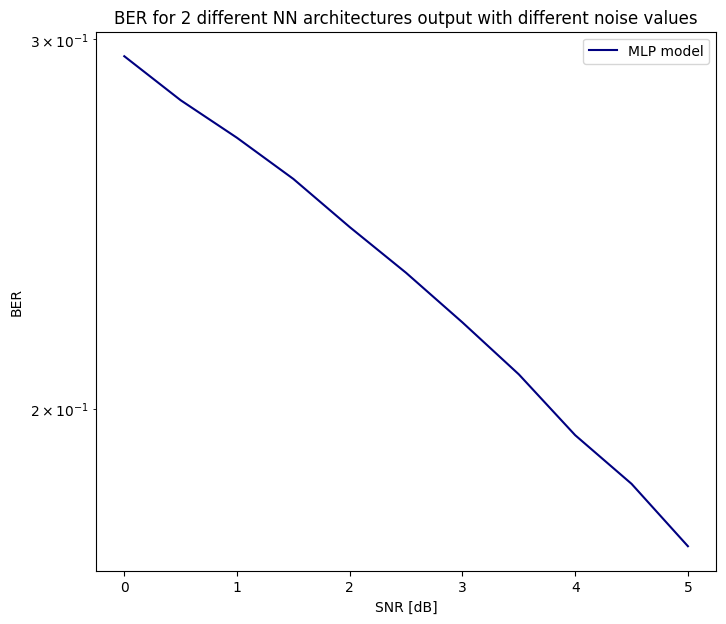

In [29]:
plt.figure(figsize=(8,7))
#plt.semilogy(SNR,BER2,color = 'Chartreuse',label='CNN model')
plt.semilogy(SNR,BER,color='Navy',label='MLP model')
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.title('BER for 2 different NN architectures output with different noise values')
plt.legend()
plt.show()

In [ ]:
#Train with noise
BER3 = []
SNR1 = [5,4.5,4,3.5,3,2.5,2,1.5,1,0.5,0]
for snr in SNR1:
    noisy_mod_signal = AWGN(mod_signal,snr)
    M1 = reshape(noisy_mod_signal,100000)
    model.fit(M1,bits,epochs=100,batch_size=32)
    signal = AWGN(test_mod_signal,snr)
    N1 = reshape(signal,1000000)
    output1 = model.predict(N1)
    for i in range(len(output1)):
        if output1[i]>=0.5:
            output1[i]=1
        else:
            output1[i]=0
    output1 = output1.reshape(1000000)
    BER3.append(np.linalg.norm(testing_bits-output1,ord=1)/1000000)
print(BER3)

Epoch 1/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.4159 - accuracy: 0.8429
Epoch 2/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.2889 - accuracy: 0.8716
Epoch 3/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.2656 - accuracy: 0.8835
Epoch 4/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.2490 - accuracy: 0.8921
Epoch 5/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.2352 - accuracy: 0.8986
Epoch 6/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.2235 - accuracy: 0.9044
Epoch 7/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.2123 - accuracy: 0.9089
Epoch 8/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.2025 - accuracy: 0.9134
Epoch 9/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.1946 - accuracy: 0.9174
Epoch 10/100
3125/3125 [==============================] - 7s 2ms/step - l

In [ ]:
plt.figure(figsize=(8,7))
plt.semilogy(SNR,BER3[::-1],color='Navy',label='MLP model')
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.title('BER for 2 different NN architectures output with different noise values')
plt.legend()
plt.show()

In [ ]:
#BER_trained_with_noise=[0.150054,0.13672,0.125647,0.116259,0.106771,0.098289,0.092816,0.087019,0.082937,0.08083,0.080237]
#BER_Original = [0.293688, 0.281029, 0.268905, 0.256675, 0.24501, 0.232775, 0.220043, 0.208411, 0.197194, 0.18499, 0.17449]